# Grab AI Challenge - Traffic Management
---



There are 2 parts of this notebook, which are **Testing** and **Exploration**. The **Testing** part is only going to use the best configuration from the analysis and experiment that have been done in exploration. If you want to see the analysis, please kindly see the **Exploration** part.

In [0]:
import datetime
import geohash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Testing

---



Based on four scenarios that have been done, the best predictive model is achieved by using Random Forest Regression using demand and day based modeling. There are three parts, which are:
1. **Creating the Model**: this part is for creating the model using the best configuration. Change the file name if you want to change the training data.
2. **Testing the Model**: this part is for testing the model from part 1. Change the file name if you want to change the testing data.
3. **Predict the Future**: this part is for predicting the T+1 until T+5 for every Geohash.

## Creating the Model

In this part, we use Random Forest Regression using day and demand based modeling. So what is day and demand based modeling?
* Day based modeling is like seasonality indicator for every day (Monday - Sunday). I use this metrics because, based on analysis that I have done, every day have a different behavior, so I think it's necessary to add the indicator. I pick the indicator based on analysis, which day is Monday, which day is Tuesday, and so on.
* Demand based modeling is also like sesonality indicator, but demand indicator is based on its demand. So, based on analysis too, I don't see any significant demand behavior differences between one another. But the differences that I see is there are several area that have a bigger demand than the other. So what I do is, i categorize the data based on its demand using percentile.

There are several preprocessing that we need to obtain several metrics:

1. Import data training
2. Extract latitude and longitude from geohash6
2. Extract hour and minute from timestamp
3. Create day_data for day based modeling
4. Function for location based modeling
5. Train the model

### Import data training

In [0]:
'''CHANGE PART'''
train_data_source = 'training.csv'
data = pd.read_csv(train_data_source)

### Extract latitude and longitude from geohash6

In [0]:
geohashes_data = pd.DataFrame({'count':data.groupby('geohash6').size()}).reset_index().sort_values(by=['count'],ascending=False)
geohashes_data['latitude'] = 0
geohashes_data['longitude'] = 0
for index, row in geohashes_data.iterrows():
    coordinate = geohash.decode(row['geohash6'])
    geohashes_data.loc[index,'latitude'] = coordinate[0]
    geohashes_data.loc[index,'longitude'] = coordinate[1]
result = pd.merge(data, geohashes_data, on='geohash6', how='inner').sort_values(by=['count'],ascending=False)

### Extract hour and minute from timestamp

In [0]:
result[['hour','minute']] = result['timestamp'].str.split(':', expand=True).astype(int)
result['day_of_week'] = result['day']%7
result['total_minute'] = result['hour']*60 + result['minute']
result.head()

geohash6  day timestamp  ...  minute  day_of_week  total_minute
465712    qp03wz   61      22:0  ...       0            5          1320
470144    qp03wz   13       7:0  ...       0            6           420
3321030   qp03xw   54      1:15  ...      15            5            75
3321031   qp03xw   56     14:45  ...      45            0           885
3321032   qp03xw   19     11:45  ...      45            5           705

[5 rows x 11 columns]

### Create day_data for day based modeling

In [0]:
day_data = pd.DataFrame(data={
    'day_of_week':[0,1,2,3,4,5,6],
    'is_weekday':[1,1,1,1,0,0,0],
    'is_friday':[0,0,0,0,1,0,0],
    'is_saturday':[0,0,0,0,0,1,0],
    'is_sunday':[0,0,0,0,0,0,1],
})

### Function for demand based modeling

In [0]:
def funcAggregateLocation(row):
  if (row['demand'] <= 0.018):
    return 0
  elif(row['demand'] > 0.018 and row['demand'] < 0.12):
    return 1
  elif(row['demand'] >= 0.12):
    return 2

### Train the model

In [0]:
train_data = pd.merge(result, day_data, on='day_of_week', how='inner').sort_values(by=['count'],ascending=False)
train_data['location_group'] = train_data.apply(funcAggregateLocation, axis=1)

X_train = train_data[['day','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday','location_group']]
y_train = train_data['demand']

rf = RandomForestRegressor().fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Testing the Model

There are four new metrics that are obtained from the analysis of data, which are `is_friday`, `is_saturday`, `is_sunday`, and `demand_group`. We need to do further analysis for the dataset. Since we can't see the testing data to analyze it and lack the demand to extract the feature, I try to extract the feature by seeing the data pattern.

For `is_friday`, `is_saturday`, `is_sunday`, actually we just need to recognize one day, to recognize the whole week. I choose to recognize Sunday from the data. Why? Because for every cyle of week Sunday always have the same behavior. On Fig 1., Sunday always have the lowest demand of the whole week. But, since I don't have any information about the demand, I try to find the correlation between `demand` and avaliable variables. Based on Fig 6, `count` have a high positive correlation to `demand`.  `count` is the number of data group by geohash.It means, if the demand is bigger, the count value should get bigger too. Because `count` is positively correlated with demand, we can assume that for every cycle, the day when the lowest `count` showed up is Sunday. And I guess it still makes sense because area with higher number of data means that the area have a busier demand too. 

How about `demand_group`? We don't have any information about demand, so what we do here is we are going to find the `demand_group` for every testing data and T+1 until T+5 time from the last T. Based on analysis, location, time, and `day_of_week` significantly influence the demand and we can see in Fig 1., that the pattern for every week is tend to be similar. We already have a training data that contain `demand_group`. In other words, on location _x_, at day_of_week  _dow_ and time _t_ will have similar demand with the last week. So we find the maximum demand for location _y_, day_of_week _dow_ and time _t_. We use maximum value, because on Fig 1., on weekly basis, the demand increased, so we choose the maximum value.


There are several preprocessing that we need to obtain several metrics:

1. Import data test
2. Extract latitude and longitude from **geohash6**
2. Extract hour and minute from **timestamp**
3. Preprocess the data to get `is_sunday`, `is_friday`, and `is_saturday`
4. Preprocess the data to get `demand_group`
5. Testing the model and performances

### Import data test

In [0]:
'''CHANGE THE PART'''
data_t = pd.read_csv("testing.csv", index_col=0)

### Extract latitude and longitude from geohash6

In [0]:
result_test = pd.merge(data_t, geohashes_data, on='geohash6', how='inner').sort_values(by=['count'],ascending=False)

### Extract hour and minute from timestamp

In [0]:
result_test[['hour','minute']] = result_test['timestamp'].str.split(':', expand=True).astype(int)
result_test['day_of_week'] = result_test['day']%7
result_test['total_minute'] = result_test['hour']*60 + result_test['minute']
result_test.head()

geohash6  day timestamp  ...  minute  day_of_week  total_minute
313956   qp03xw   54     14:45  ...      45            5           885
203103   qp03yb   61      2:30  ...      30            5           150
203090   qp03yb   61      4:30  ...      30            5           270
203091   qp03yb   58     12:30  ...      30            2           750
203092   qp03yb   59     12:30  ...      30            3           750

[5 rows x 11 columns]

### Preprocess the data to get `is_sunday`, `is_friday`, and `is_saturday`

In [0]:
temp = result_test.groupby('day_of_week', as_index=False)['count'].count()
temp

day_of_week   count
0            0  140237
1            1  139980
2            2  140872
3            3  143441
4            4  148697
5            5  142915
6            6  136687

In [0]:
sunday_idx = temp.idxmin()['count']
saturday_idx = sunday_idx-1 if sunday_idx-1 > -1 else sunday_idx+6
friday_idx = sunday_idx-2 if sunday_idx-2 > -1 else sunday_idx+5
thursday_idx = sunday_idx-3 if sunday_idx-3 > -1 else sunday_idx+4
wednesday_idx = sunday_idx-4 if sunday_idx-4 > -1 else sunday_idx+3
tuesday_idx = sunday_idx-5 if sunday_idx-5 > -1 else sunday_idx+2
monday_idx = sunday_idx-6 if sunday_idx-6 > -1 else sunday_idx+1

In [0]:
day_data = pd.DataFrame(data={
    'day_of_week':[0,1,2,3,4,5,6],
    'is_friday':[0,0,0,0,0,0,0],
    'is_saturday':[0,0,0,0,0,0,0],
    'is_sunday':[0,0,0,0,0,0,0],
})
for idx, row in day_data.iterrows():
  if(row['day_of_week'] == friday_idx):
    row['is_friday'] = 1
  elif(row['day_of_week'] == saturday_idx):
    row['is_saturday'] = 1
  elif(row['day_of_week'] == sunday_idx):
    row['is_sunday'] = 1
    
day_list = {sunday_idx: 6, saturday_idx: 5, friday_idx: 4, thursday_idx: 3, wednesday_idx: 2, tuesday_idx: 1, monday_idx: 0}

In [0]:
test_df = pd.merge(result_test, day_data, on='day_of_week', how='inner').sort_values(by=['day','total_minute'],ascending=True)

if(sunday_idx != 6):
  test_df['day_of_week'] = test_df['day_of_week'].map(day_list)

test_df.head()

geohash6  day timestamp  ...  is_friday  is_saturday  is_sunday
427324   qp03yb   48       0:0  ...          0            0          1
427398   qp03wf   48       0:0  ...          0            0          1
427543   qp03xw   48       0:0  ...          0            0          1
427846   qp03wz   48       0:0  ...          0            0          1
428056   qp03xx   48       0:0  ...          0            0          1

[5 rows x 14 columns]

### Preprocess the data to get demand_group



In [0]:
temp = train_data[['geohash6','day_of_week','location_group','total_minute']]
temp_loc = temp.groupby(['geohash6','total_minute','day_of_week'], as_index=False).max()

In [0]:
test_data = pd.merge(test_df, temp_loc, on=['geohash6','day_of_week','total_minute'])
test_data = test_data.fillna(value={'location_group':1})

### Testing the testing model and performances

In [0]:
X_test = test_data[['day','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday','location_group']]
y_test = test_data['demand']

y_pred = rf.predict(X_test)
print(mean_squared_error(y_pred,y_test))

0.0010317535082832907


##Predict Future Data


There are several preprocessing steps that we need to do to obtain several metrics:

1. Create data for T+1 - T+5
4. Preprocess the data to get `demand_group`
5. Predict the future data
4. Check model performances

The result of prediction is DataFrame with column:  `day`, `latitude`, `longitude`, `hour`, `minute`, `is_friday`, `is_saturday`, `is_sunday`, `location_group`, and `pred_demand`. The dataframe is sorted by geohash6, day, and hour, so to check the model performances, just merge the demand data to `X_future` dataframe with column name demand and uncomment Section 4.



### Create data for T+1 - T+5

In [0]:
day_idx = test_data.groupby(['geohash6'])['day'].transform(max) == test_data['day']
data_day_max = test_data[day_idx]

hour_idx = data_day_max.groupby(['geohash6'])['total_minute'].transform(max) == data_day_max['total_minute']
data_day_hour_max = data_day_max[hour_idx]

In [0]:
future_data = pd.DataFrame(columns=['geohash6', 'day', 'count', 'latitude',
       'longitude', 'hour', 'minute', 'day_of_week', 'total_minute',
       'is_friday', 'is_saturday', 'is_sunday'])
for idx, row in data_day_hour_max.iterrows():
  t = 0
  geohashs = []
  latitudes = []
  longitudes = []
  hours = []
  minutes = []
  total_minutes = []
  days = []
  day_of_weeks = []
  is_fridays = []
  is_saturdays = []
  is_sundays = []
  location_groups = []
  counts = []
  
  curr_total_minute = row['total_minute']
  while(t < 5):
    curr_total_minute +=  15
    
    if(curr_total_minute > 1425):
      curr_total_minute = 0
      day = row['day'] + 1
      day_of_week = row['day_of_week'] + 1 if day < 7 else 0
    else:
      day = row['day']
      day_of_week = row['day_of_week']
      
    
    hour = curr_total_minute//60
    minute = curr_total_minute % 60
    
    geohashs.append(row['geohash6'])
    latitudes.append(row['latitude'])
    longitudes.append(row['longitude'])
    hours.append(hour)
    minutes.append(minute)
    total_minutes.append(curr_total_minute)
    days.append(day)
    day_of_weeks.append(day_of_week)
    is_sundays.append(1) if day==6 else is_sundays.append(0)
    is_saturdays.append(1) if day==5 else is_saturdays.append(0)
    is_fridays.append(1) if day== 4 else is_fridays.append(0)
    counts.append(row['count'])
    t+=1
 
  future_data = future_data.append(pd.DataFrame({"geohash6":geohashs,'count':counts ,'latitude':latitudes, 'longitude':longitudes, 'hour':hours, 'minute':minutes, 
                                     'total_minute':total_minutes, 'day':days, 'day_of_week':day_of_weeks, 'is_sunday':is_sundays,
                                    'is_saturday':is_saturdays, 'is_friday':is_fridays}), ignore_index=True)
  

  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Preprocess the data to get demand_group

In [0]:
future_data = pd.merge(future_data, temp_loc, on=['geohash6','day_of_week','total_minute'])
future_data = future_data.fillna(value={'location_group':1})
future_data = future_data.sort_values(by=['geohash6','day','hour'])

### Predict the future data

In [0]:
X_future = future_data[['day','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday','location_group']]
y_pred = rf.predict(X_future)

X_future['pred_demand'] = y_pred
X_future.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


day  latitude  longitude  ... is_sunday location_group pred_demand
3276  61 -5.484924  90.653687  ...         0              0    0.009581
3037  61 -5.479431  90.653687  ...         0              0    0.007163
3038  61 -5.479431  90.653687  ...         0              0    0.008732
3039  61 -5.479431  90.653687  ...         0              1    0.034786
3040  61 -5.479431  90.653687  ...         0              0    0.008391

[5 rows x 10 columns]

### Check model performances

In [0]:
'''CHANGE THIS PART'''
#y_true = X_future['demand']
#y_pred = X_future['pred_demand']
#mean_squared_error(y_true,y_pred)

'CHANGE THIS PART'

#Exploration

---

The exploration, analysis, and experiment that I have done.

# Introduction



 For exploration part, there are several steps, which are:
1. Problem Analysis
2. Data Import
3. Data Exploration and Feature Engineering
4. Predictive Modeling
5. Creating the Model
6. Testing the data

# Problem Analysis

**Problem Statement**

Economies in Southeast Asia are turning to AI to solve traffic congestion, which hinders mobility and economic growth. The first step in the push towards alleviating traffic congestion is to understand travel demand and travel patterns within the city.
Can we accurately forecast travel demand based on historical Grab bookings to predict areas and times with high travel demand?

**Analysis**

In online transportation domain, one of the most important things is availability. For every demand that comes from customer, there must be available driver. To achieve its availability, one of the common way is by predicting the demand for every area at a given time. This prediction is beneficial for driver and customer too. The system can recommend the driver to go to the high-demand area at busy time, so, at busy time when demands are high, there's still enough driver to fulfill the order. The driver can fulfill the demand at the shorter time and the price too will decrease. For customer, the system can recommend customer to use GrabShare at busy time in their area. Why GrabShare? Imagine if at 17.00 p.m, A, B, and C from near location use Grab to the same mall, they will order three different GrabCar, this will increase the traffic, the cost, and pollution. A, B, and C don't want to use GrabShare, because maybe they don't want to spend more time if the driver have to pick passenger from far area (because the driver gonna pick all the passengers and then drop-off the passengers). But imagine, if the system can give them a recommendation, like 'In 17.00 p.m there's a high demand in your area, why not use GrabShare? Cheaper and you save the world by reducing traffic jam and polution'. Happy customer, happy driver.

The question is, how to predict the demand at a given time in a certain location, accurately?

# Data Import

In [0]:
data = pd.read_csv(train_data_source)

# Data Exploration and Feature Engineering

In [0]:
data.head()

geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468

### Data info, null values and description

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


In [0]:
data.isnull().values.any()

False

In [0]:
data.describe()

day        demand
count  4.206321e+06  4.206321e+06
mean   3.145299e+01  1.050907e-01
std    1.768278e+01  1.592655e-01
min    1.000000e+00  3.092217e-09
25%    1.600000e+01  1.867379e-02
50%    3.200000e+01  5.043463e-02
75%    4.700000e+01  1.208644e-01
max    6.100000e+01  1.000000e+00

### Geohash Decoding

In [0]:
print("Number of data: ",len(data))
print("Number of different geohash6: ",len(data.geohash6.unique()))
print("Average: ",len(data)/len(data.geohash6.unique()))

Number of data:  4206321
Number of different geohash6:  1329
Average:  3165.027088036117


In [0]:
geohashes_data = pd.DataFrame({'count':data.groupby('geohash6').size()}).reset_index().sort_values(by=['count'],ascending=False)
geohashes_data.head()

geohash6  count
232   qp03wz   5846
261   qp03xw   5846
215   qp03wf   5846
275   qp03yb   5846
507   qp092m   5845

In [0]:
geohashes_data['latitude'] = 0
geohashes_data['longitude'] = 0
for index, row in geohashes_data.iterrows():
    coordinate = geohash.decode(row['geohash6'])
    geohashes_data.loc[index,'latitude'] = coordinate[0]
    geohashes_data.loc[index,'longitude'] = coordinate[1]

geohashes_data.head()

geohash6  count  latitude  longitude
232   qp03wz   5846 -5.320129  90.653687
261   qp03xw   5846 -5.325623  90.686646
215   qp03wf   5846 -5.347595  90.653687
275   qp03yb   5846 -5.314636  90.653687
507   qp092m   5845 -5.375061  90.719604

In [0]:
result = pd.merge(data, geohashes_data, on='geohash6', how='inner').sort_values(by=['count'],ascending=False)

### Timestamp Decoding

`day_of_week` is the number of day on 7-day cycle. Number of day is obtained by taking the mod of `day` to 7 (number of day in one week). `day_of_week` consists of number [0, 1, 2, 3, 4, 5, 6]. The `day_of_week` for 1st day is 1 and for 7th is 0, and so on.

In [0]:
result[['hour','minute']] = result['timestamp'].str.split(':', expand=True).astype(int)
result['day_of_week'] = result['day']%7
result['total_minute'] = result['hour']*60 + result['minute']
result.head()

geohash6  day timestamp  ...  minute  day_of_week  total_minute
465712    qp03wz   61      22:0  ...       0            5          1320
470144    qp03wz   13       7:0  ...       0            6           420
3321030   qp03xw   54      1:15  ...      15            5            75
3321031   qp03xw   56     14:45  ...      45            0           885
3321032   qp03xw   19     11:45  ...      45            5           705

[5 rows x 11 columns]

### Data Visualization and Analysis

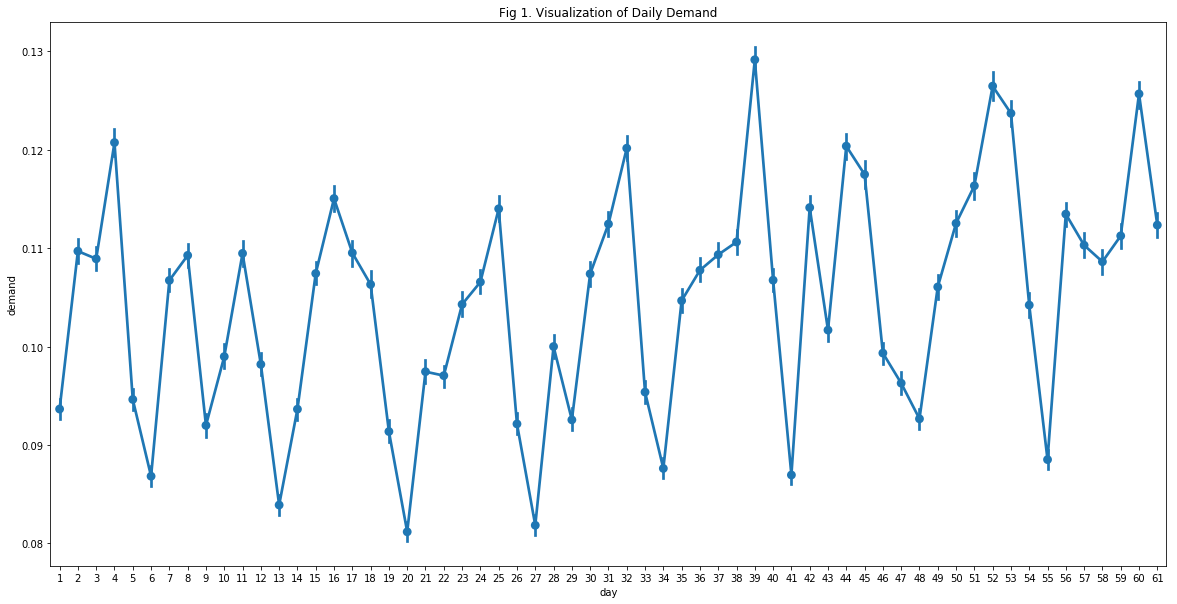

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Fig 1. Visualization of Daily Demand')
sns.pointplot(data=result[['demand', 'day']],
            x='day', y='demand', ax=ax)

Based on Fig 1, there are several interesting patterns. For every 7-day cycle, the 4th day almost always have a highest demand, except on 3rd cycle, when the 2nd day have a highest demand on that cycle. This exception might be caused by public holiday and bad weather at busy time, which cause people to choose Grab instead of public transportation. 

Another thing is on 5th and 6th day for every cycle, the demand significantly decrease. This might be caused by people using their private car or didn't do any mobility to another place on those days.

On the 7th day, the demand is quite high, which maybe caused of many people need a faster transportation than a public transportation.

Based on this pattern, I assumed that the 1st day on data in Tuesday. So in `day_of_week` conversion, we can assume that:

|day | day_of_week | assumption_day |
|-----|-------|-----------------------|
|7| 0 | Monday |
|1| 1 | Tuesday |
|2 | 2 | Wednesday|
|3|3 | Thursday|
|4|4 | Friday |
|5|5| Saturday|
|6|6| Sunday|


Deeper analysis will be done to support the assumption.


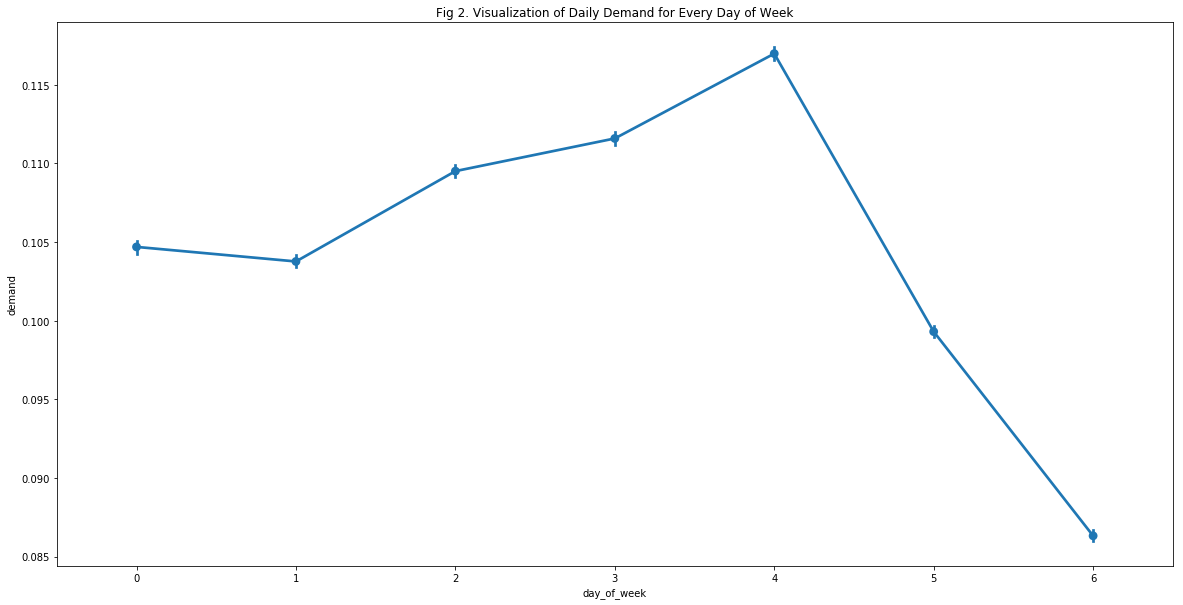

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Fig 2. Visualization of Daily Demand for Every Day of Week')
sns.pointplot(data=result[['demand', 'day_of_week']],
            x='day_of_week', y='demand', ax=ax)


Based on Fig 2, on 0 until 3rd day, demand average is similar, but on the 4th day, the demand increases. On 5th and 6th day, the demand decreases. Based on the assumption, the 4th day in Friday, the day which people tend to go out after works, because the next day is weekend. TGIF. And on 5th and 6th day, which are Saturday and Sunday, people tend to bring their own transportation or just rest in home. This visualization support my assumption.


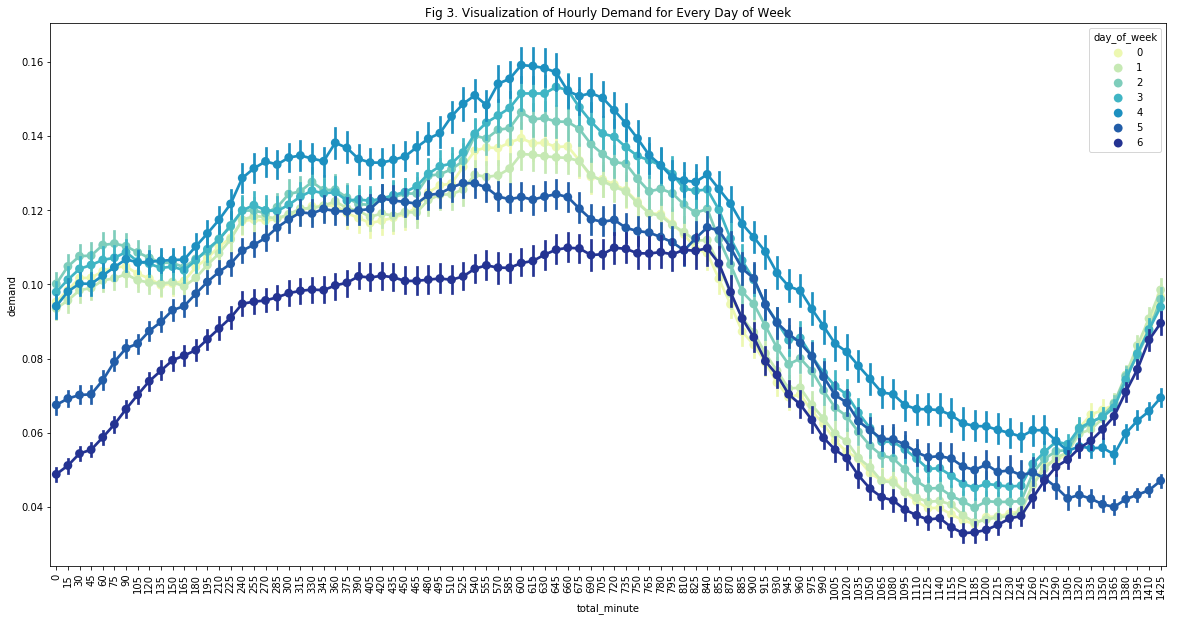

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
ax.set_title('Fig 3. Visualization of Hourly Demand for Every Day of Week')
sns.pointplot(data=result[['total_minute',
                       'demand', 'day_of_week']],
            x='total_minute', y='demand', hue='day_of_week', ax=ax, palette="YlGnBu")

On Fig 3., I conclude that pattern on 0 to 4th day is quite similar, except 4th day after minute 1305, the pattern is different. And on the 4 th day before minute 1305 and after minute 90, the demand is always the highest. The demand on minute 480 until 690 is high, and this makes sense, since people tend to leave home at that time. And on minute 840, the demand is decreasing, because people tend to start their activity on their office, or school, so that there's no much mobility. The demand increased again at minute 1305, because people tend to go back to home.  

On 0, 1st, 2nd, 3rd, and 6th, in midnight hour, the demand is quite high, probably because there's no public transportation. Another reason is 0, 1, 2, and 3 is the weekday, and people tend to go with business partner and customer until midnight and sometimes they drink alcoholic drinks. It will be safer to use Grab rather than bring their own car after drinking alcohol.

On 4th and 5th day, at midnight, the demand is not that much. On Friday and Saturday, public transportation is operating longer than usual, so at midnight, usually the public transportation is still available. Another reason is, at Friday people tend to go immediately after finishing work to meet their friends, wife, or husband in the mall or restaurant. But when returning home, sometimes they will go back together with their friends or wife or husband. For example, at 18.30, A dan B is husband and wife that gonna have a candlelight dinner at the fancy restaurant, and since A and B work in different office, they order two different Grab at 18.00. But when they return home at midnight, they only need to order one Grab. 

On 5th and 6th day, the demand is decreasing, but for the whole day until 840, the demand is quite equal. This is because, on Saturday and Sunday, people tend to start their activities based on their preferences. Some people like to go out at 7 in the morning, but maybe some people just woke up at 11, and so on. But on weekday, the activity starts at similar time, like your working hour is from 9 am to 9 pm and also your co-workers.

On the 6th day, which is Sunday, the demand is quite high at night, but suddenly decreases after the midnight. This probably because of people tend to sleep earlier at Sunday, because tomorrow is Monday. Different with the 4th and 5th, demand at night is not that high, but after midnight, the demand is high. Because on Friday and Saturday, people tend to return home after the midnight.




In [0]:
plt.figure(figsize=(20, 40))
heatmap_data = pd.pivot_table(result, values='demand', 
                     index=['geohash6'], 
                     columns='day_of_week')
ax = plt.axes()
ax.set_title('Fig 4. Demand per Geohash daily')
sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax)

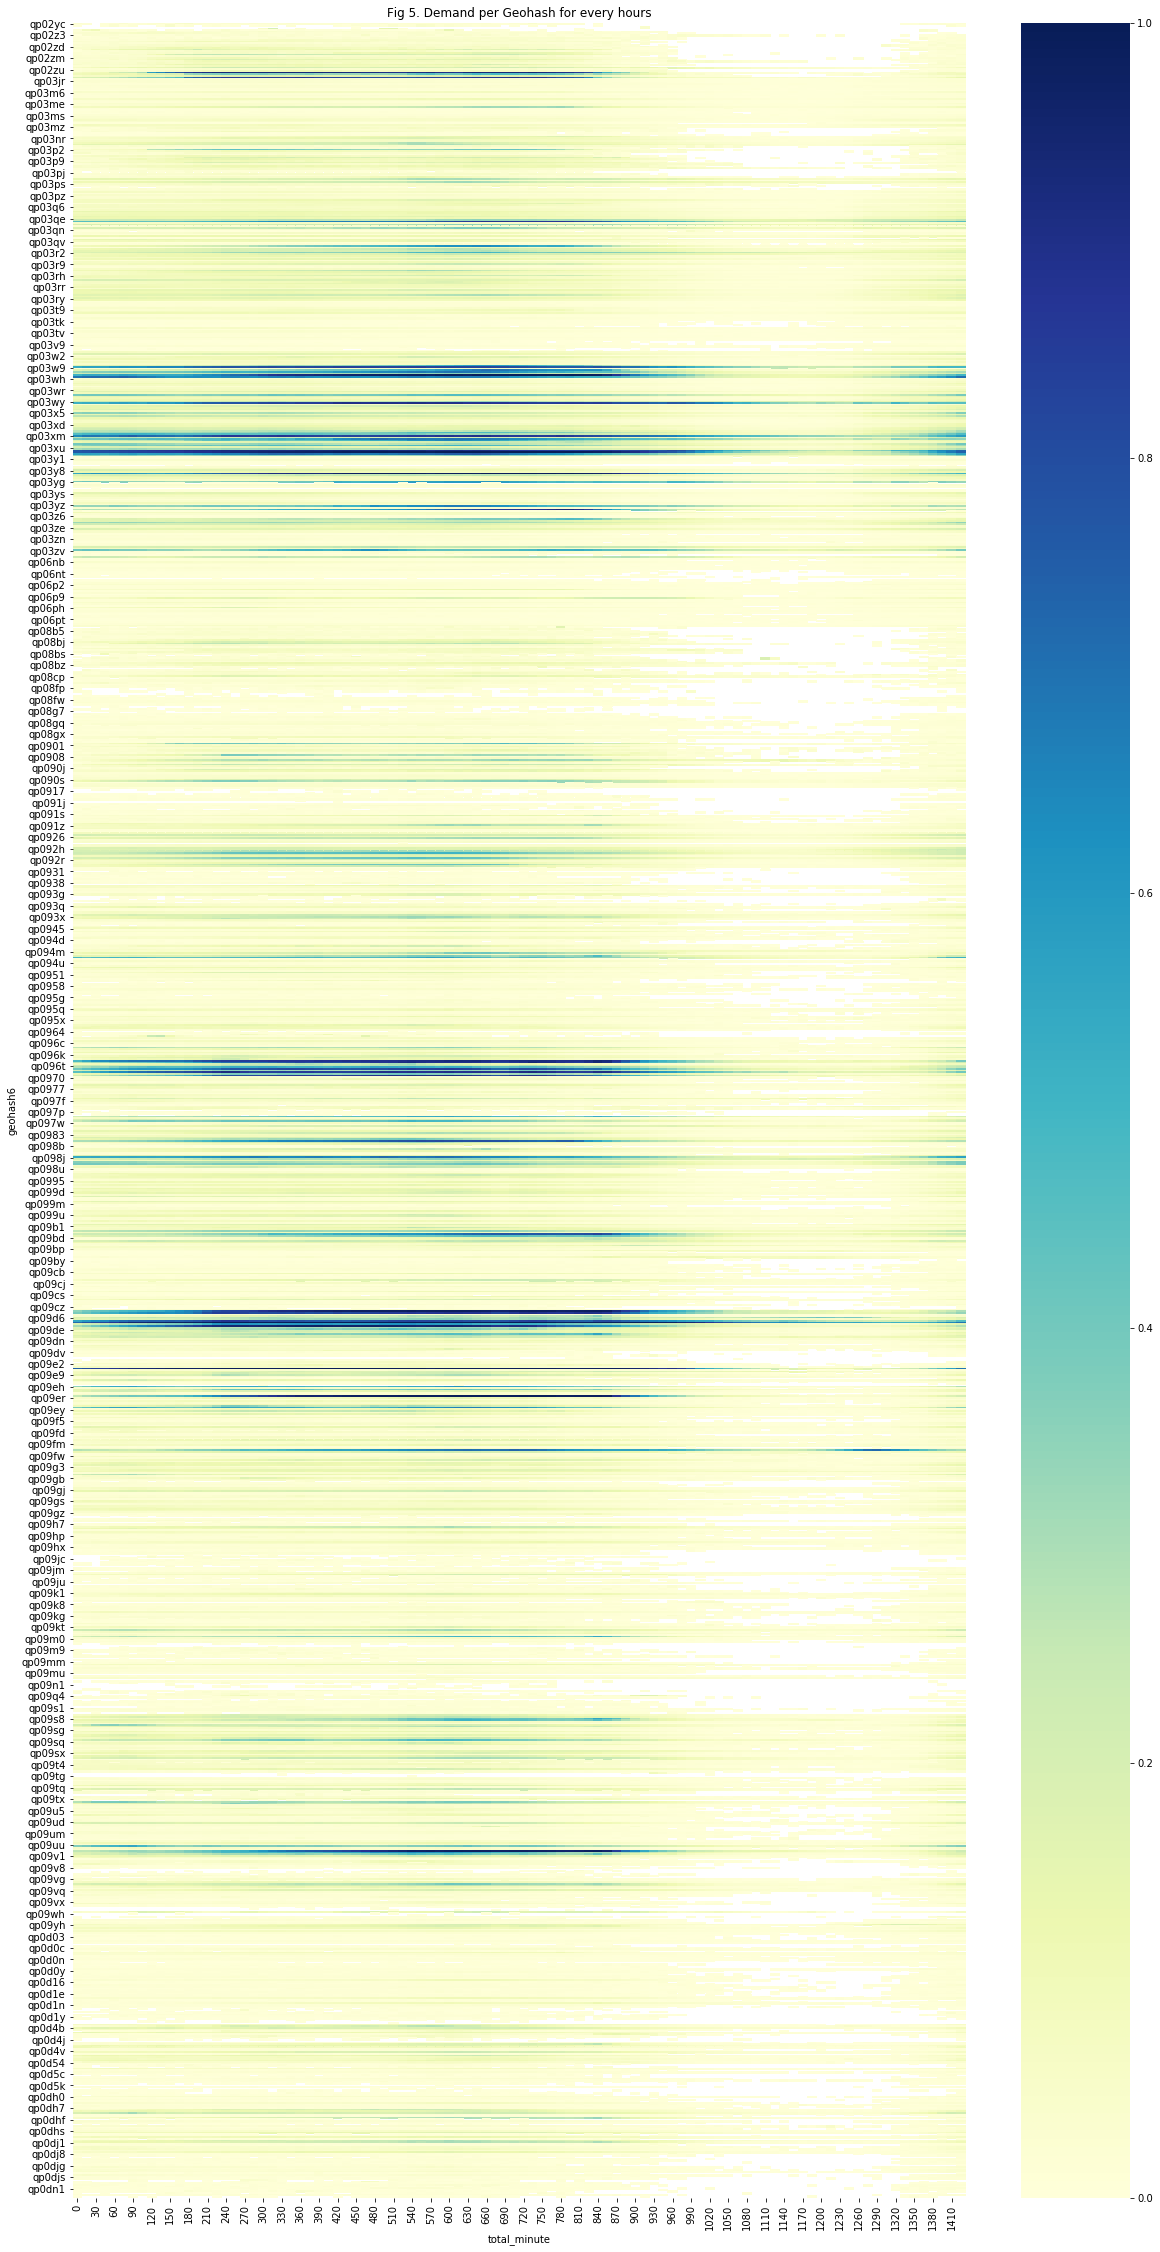

In [0]:
plt.figure(figsize=(20, 40))
heatmap_data = pd.pivot_table(result, values='demand', 
                     index=['geohash6'], 
                     columns='total_minute')
ax = plt.axes()
ax.set_title('Fig 5. Demand per Geohash for every hours')
sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax)

Fig 1. until Fig.3 mostly visualize about demand and time, but on Fig 4. and Fig 5. mostly visualize about demand and location. In general, different locations should have different behavior and busy time. Like home, CBD, school, and mall will have different behavior and busy time.

But based on the visualization, there is no significant difference between one and another location. The busy time on data mostly happens on 5 am until 14.00 pm. Maybe it's because the area is the crowded area and on that area there are home, apartment, office building, mall, etc. But, there are interesting facts, some location have a higher demand than the other area. 


### Why not drop data to overcome imbalance data? 

There are 4206321 number of data and there are 1329 number of different geohash6. So in average, there are about 3166 data for every geohash. But, this geohash is divided again by 15 minute interval for every day. And there are 61 day, so the data is not that much, that's why I'm trying to keep and use all the data. 

Besides that, with asumption that these data is real, i think it's not right to just drop the imbalance data in this problem. Let's say the imbalance data in one of the area which the demand is not that much, but there's still a demand in that place, so it means that there's still demand that needs to fulfill. And in my opinion, availability for every demand in every area is one of the important metrics for transportation application.

# Predictive Modeling

Based on analysis, there are two hypothesis:

1.   In this problem, there are no significant behavior difference between one location and another. The differences between one location to the other is demand. There are several areas which have high demand, medium demand, and low demand.
2.   Day significantly influences the demand, because several days have a different demand pattern.

Experiment will be conducted using four methods, which are multiple linear regression, decision tree learning, random forest regressor, and gradient boosting regressor. Data will be split into training and validation data. Based on hypothesis, there are four scenarios that will be done: 


1.   **All Data**

Predictive modeling using all the data and features.
2.   **Demand based Modeling**

Geohash data will be classify into several class, based on its demand. There three class, high-demand area, medium-demand area, and low-demand area.

3.   **Day based Modeling**

Data will be classify based on `day_of_week`. The grouping is:

    * Weekdays (Monday-Thursday)
    * Friday
    * Saturday
    * Sunday
    
    
4.   **Demand and Day based Modeling**

Combine the demand and day based modeling.





  




## Split Training and Validation data

Based on my experience, in spliting training and validation for time based data, it's a convenient way to pick the validation data from the last week or the last 7 days data. This is because of normally, we can see the similar pattern between every week. So if we train the data using N - 1 first week and use the the last week as validation data, the validation data supossed to have similar pattern with training data. 



In [0]:
train = result.loc[result['day']<=54]
validate = result.loc[result['day']>54]

## 1. All data

We use all the data and features to make the model

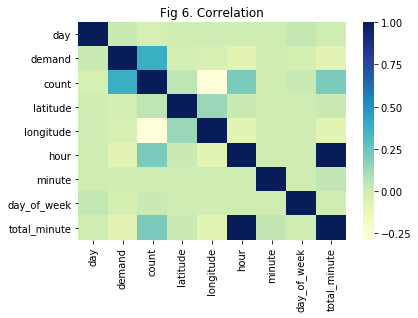

In [0]:
corr = train.corr()
ax = plt.axes()
ax.set_title('Fig 6. Correlation')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax, cmap='YlGnBu')

We choose to not use `total_minute`, since it has multicolinearity with `hour`.

In [0]:
X_train = train[['day','count','latitude','longitude','hour','minute','day_of_week']]
y_train = train['demand']

In [0]:
X_validate = validate[['day','count','latitude','longitude','hour','minute','day_of_week']]
y_validate = validate['demand']

### Multiple Linear Regressor

In [0]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.02196334104686717

### Decision Tree Regressor

In [0]:
dtl = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = dtl.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.00435547142789047

### Random Forest Regressor

In [0]:
rf = RandomForestRegressor().fit(X_train,y_train)
y_pred = rf.predict(X_validate)
mean_squared_error(y_validate,y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.0032501681311471304

### Gradient Boosting Regressor

In [0]:
gbr = GradientBoostingRegressor().fit(X_train,y_train)
y_pred = gbr.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.0077832703583718575

## 2.Demand based Modeling

In this scenario, we try to classify the model based on its demand. Demand under and at 0.018 will be classified to class 0, demand between 0.018 and 0.12 will be classified to class 1, and deman bigger than 0.12 will be classified to class 2. This constraints is based on the percentile of the demand data, which can be seen in **Data Exploration and Feature Engineering** part.

In [0]:
def funcAggregateLocation(row):
  if (row['demand'] <= 0.018):
    return 0
  elif(row['demand'] > 0.018 and row['demand'] < 0.12):
    return 1
  elif(row['demand'] >= 0.12):
    return 2

In [0]:
train_location = train.copy()
train_location['location_group'] = train_location.apply(funcAggregateLocation, axis=1)

validate_location = validate.copy()
validate_location['location_group'] = validate_location.apply(funcAggregateLocation, axis=1)

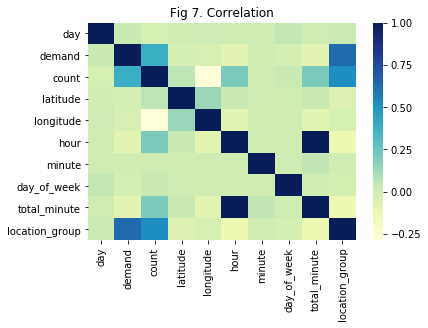

In [0]:
corr = train_location.corr()
ax = plt.axes()
ax.set_title('Fig 7. Correlation')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax, cmap='YlGnBu')

We choose to not use `total_minute` since it has multicolinearity with `hour` and `count` since it has multicolinearity with `location_group`

In [0]:
X_train = train_location[['day','latitude','longitude','hour','minute','day_of_week','location_group']]
y_train = train_location['demand']

X_validate = validate_location[['day','latitude','longitude','hour','minute','day_of_week','location_group']]
y_validate = validate_location['demand']

### Multiple Linear Regression

In [0]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.01598612685750992

### Decision Tree Regressor

In [0]:
dtl = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = dtl.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.003624108263385111

### Random Forest Regressor

In [0]:
rf = RandomForestRegressor().fit(X_train,y_train)
y_pred = rf.predict(X_validate)
mean_squared_error(y_validate,y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.0026220057535487357

### Gradient Boosting Regressor

In [0]:
gbr = GradientBoostingRegressor().fit(X_train,y_train)
y_pred = gbr.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.010551559512633832

## 3. Day based Modeling

In [0]:
day_data = pd.DataFrame(data={
    'day_of_week':[0,1,2,3,4,5,6],
    'is_weekday':[1,1,1,1,0,0,0],
    'is_friday':[0,0,0,0,1,0,0],
    'is_saturday':[0,0,0,0,0,1,0],
    'is_sunday':[0,0,0,0,0,0,1],
})
day_data.head()

day_of_week  is_weekday  is_friday  is_saturday  is_sunday
0            0           1          0            0          0
1            1           1          0            0          0
2            2           1          0            0          0
3            3           1          0            0          0
4            4           0          1            0          0

In [0]:
train_day = pd.merge(train, day_data, on='day_of_week', how='inner').sort_values(by=['count'],ascending=False)
validate_day = pd.merge(validate, day_data, on='day_of_week', how='inner').sort_values(by=['count'],ascending=False)

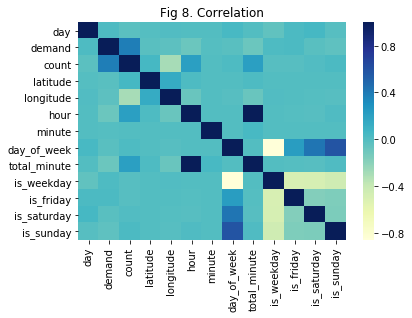

In [0]:
corr = train_day.corr()
ax = plt.axes()
ax.set_title('Fig 8. Correlation')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax, cmap='YlGnBu')

We choose to not use `total_minute` since it has multicolinearity with `hour`, 

`day_of_week` since it has multicolinearity with `is_sunday`, `is_saturday`, `is_friday`, `is_weekday`,

`is_weekday` since it has multicolinearity with `is_sunday`, `is_saturday`, `is_friday`.



In [0]:
X_train = train_day[['day','count','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday']]
y_train = train_day['demand']

X_validate = validate_day[['day','count','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday']]
y_validate = validate_day['demand'] 

### Multiple Linear Regression

In [0]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.021877190149731364

### Decision Tree Regressor

In [0]:
dtl = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = dtl.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.004215726948688878

### Random Forest Regressor

In [0]:
rf = RandomForestRegressor().fit(X_train,y_train)
y_pred = rf.predict(X_validate)
mean_squared_error(y_validate,y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.003035731197093812

### Gradient Boosting Regressor

In [0]:
gbr = GradientBoostingRegressor().fit(X_train,y_train)
y_pred = gbr.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.00774906110110717

## 4. Demand and Day based Modeling

In [0]:
train_day_loc = pd.merge(train, day_data, on='day_of_week', how='inner').sort_values(by=['count'],ascending=False)
validate_day_loc = pd.merge(validate, day_data, on='day_of_week', how='inner').sort_values(by=['count'],ascending=False)

train_day_loc['location_group'] = train_day_loc.apply(funcAggregateLocation, axis=1)
validate_day_loc['location_group'] = validate_day_loc.apply(funcAggregateLocation, axis=1)

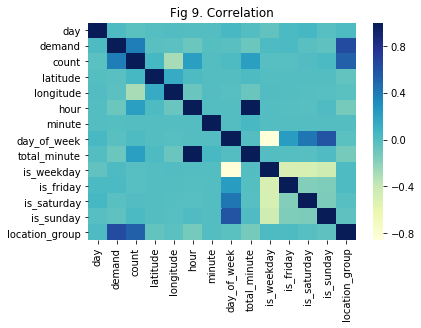

In [0]:
corr = train_day_loc.corr()
ax = plt.axes()
ax.set_title('Fig 9. Correlation')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax, cmap='YlGnBu')

We choose to not use `total_minute` since it has multicolinearity with `hour` and `count`

`count` since it has multicolinearity with `location_group` and `longitude`

`day_of_week` since it has multicolinearity with `is_sunday`, `is_saturday`, `is_friday`, `is_weekday`,

`is_weekday` since it has multicolinearity with `is_sunday`, `is_saturday`, `is_friday`.



In [0]:
X_train = train_day_loc[['day','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday','location_group']]
y_train = train_day_loc['demand']

X_validate = validate_day_loc[['day','latitude','longitude','hour','minute','is_friday','is_saturday','is_sunday','location_group']]
y_validate = validate_day_loc['demand']

### Multiple Linear Regression

In [0]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.015970159791009825

### Decision Tree Regressor

In [0]:
dtl = DecisionTreeRegressor().fit(X_train,y_train)
y_pred = dtl.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.003379880838486764

### Random Forest Regressor

In [0]:
rf = RandomForestRegressor().fit(X_train,y_train)
y_pred = rf.predict(X_validate)
mean_squared_error(y_validate,y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.0025846357947438923

### Gradient Boosting Regressor

In [0]:
gbr = GradientBoostingRegressor().fit(X_train,y_train)
y_pred = gbr.predict(X_validate)
mean_squared_error(y_validate,y_pred)

0.01057603440306289

# Creating the Model

Based on 4 scenario, the best regression model is achieved by using Random Forest Regression using demand and day based modeling. 


In [0]:
rf = RandomForestRegressor().fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Acknowledment

Thank you very much for the opportunity, so that I can participate in Grab AI Challenge. It's really great challenge and I've learned so much from doing this test. I'm really sorry for the not-so-good quality of code but I really hope that you feel satisfied with my results and analysis.

_Best regards, Irene Edria Devina_
